In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import platform
import warnings

warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
from collections import Counter
from PIL import Image
from wordcloud import WordCloud

In [2]:
path = 'c:/Windows/Fonts/malgun.ttf'
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else:
    print('Unknown system. Sorry.')

get_ipython().run_line_magic('matplotlib', 'inline')

# 1. Import data

In [21]:
df = pd.read_csv('./data/naver_shopping.txt', sep = '\t', encoding = 'utf-8', header = None)
df.columns = ['rating','text']
df.head()

,rating,text
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# 2. 데이터 살펴보기

In [22]:
# dimension
df.shape

(200000, 2)

In [23]:
# 결측치
df.isnull().sum()

rating    0
text      0
dtype: int64

In [24]:
# information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rating  200000 non-null  int64 
 1   text    200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [25]:
# reviews 변수 확인
df['text'][0]

'배공빠르고 굿'

### 평점별 리뷰 개수

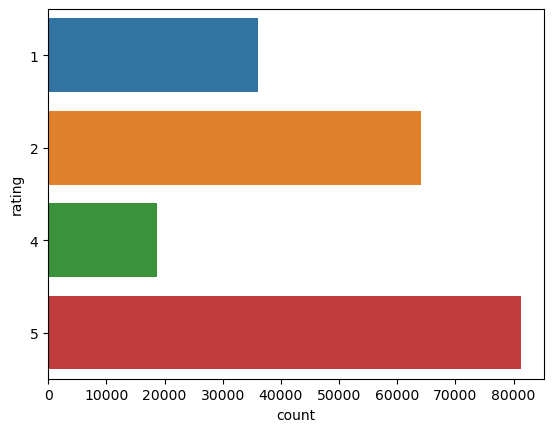

In [27]:
sns.countplot(y = 'rating', data = df);

In [28]:
df['rating'].value_counts()

5    81177
2    63989
1    36048
4    18786
Name: rating, dtype: int64

| |1점|2점|4점|5점|
|---|---|---|---|---|
|개수|36,048|63,989|18,786|81,177|

### 긍/부정 label 추가 및 확인

In [54]:
df['p/n'] = np.where(df['rating'].values > 3, 1, 0)
df.head()

,rating,text,p/n
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


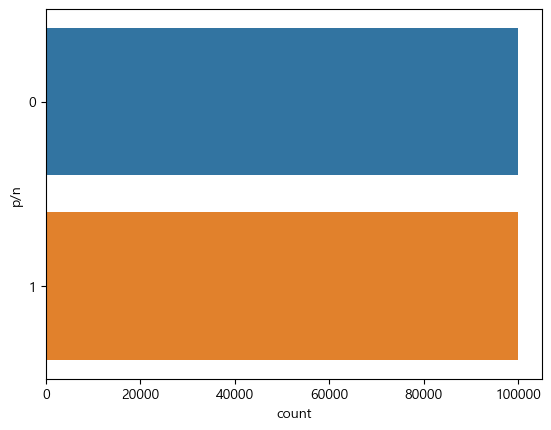

In [55]:
sns.countplot(y = 'p/n', data = df);

In [56]:
df['p/n'].value_counts()

0    100037
1     99963
Name: p/n, dtype: int64

| |긍정리뷰|부정리뷰|
|---|---|---|
|개수|100,037|99,963|
|비율 (%)|50.012|49.98|

# 3. File Decomposition

In [29]:
Score_1_Review = []

for idx, row in df.iterrows():
    if df.iloc[idx, 0] == 1 :
        Score_1_Review.append(df.iloc[idx,1])

filePath = './Score_1_Review.txt'
with open(filePath, 'w+', encoding = 'utf-8') as lf:
    lf.write(' '.join(Score_1_Review))

In [30]:
Score_2_Review = []

for idx, row in df.iterrows():
    if df.iloc[idx, 0] == 2 :
        Score_2_Review.append(df.iloc[idx,1])

filePath = './Score_2_Review.txt'
with open(filePath, 'w+', encoding = 'utf-8') as lf:
    lf.write(' '.join(Score_2_Review))

In [31]:
Score_4_Review = []

for idx, row in df.iterrows():
    if df.iloc[idx, 0] == 4 :
        Score_4_Review.append(df.iloc[idx,1])

filePath = './Score_4_Review.txt'
with open(filePath, 'w+', encoding = 'utf-8') as lf:
    lf.write(' '.join(Score_4_Review))

In [32]:
Score_5_Review = []

for idx, row in df.iterrows():
    if df.iloc[idx, 0] == 5 :
        Score_5_Review.append(df.iloc[idx,1])

filePath = './Score_5_Review.txt'
with open(filePath, 'w+', encoding = 'utf-8') as lf:
    lf.write(' '.join(Score_5_Review))

# 4. Word Cloud

## (1) Score_1_Review

In [37]:
text = ''
filePath = './data/Score_1_Review.txt'
with open(filePath, "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        text += line

In [3]:
#### 불용어
stopwords = pd.read_csv('./data/korean_stopwords.txt').values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [4]:
# 전처리 - 명사 추출
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    
    tagger = Okt()
    nouns = tagger.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]           # 한 글자 키워드 제거 (ex) 것, 개, 거, 때, ...
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    
    return nouns

In [40]:
vect = CountVectorizer(tokenizer = lambda x : text_cleaning(x))
bow_vect = vect.fit_transform([text])
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis = 0)

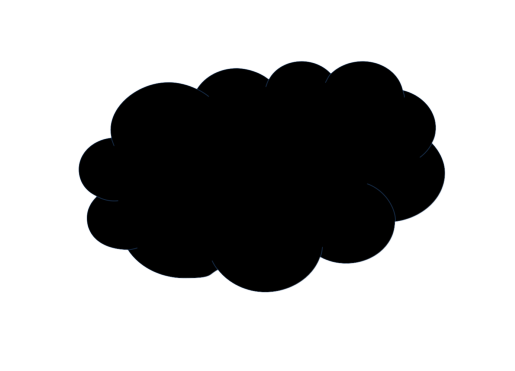

In [8]:
mask = np.array(Image.open('./cloud.png'))

plt.imshow(mask, cmap = plt.cm.gray, interpolation = 'bilinear')
plt.axis('off')
plt.show();

In [42]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'가가': 8,
 '가게': 29,
 '가격': 1476,
 '가격표': 4,
 '가계': 2,
 '가공': 14,
 '가공품': 1,
 '가관': 7,
 '가구': 58,
 '가구라': 1,
 '가구점': 2,
 '가글': 1,
 '가기': 7,
 '가까이': 44,
 '가끔': 31,
 '가나': 49,
 '가나다': 11,
 '가나다라': 1,
 '가년': 2,
 '가늠': 3,
 '가늡니': 1,
 '가능': 16,
 '가능성': 2,
 '가다가': 2,
 '가다랑어': 1,
 '가닥': 13,
 '가당': 3,
 '가대': 1,
 '가도': 13,
 '가독성': 1,
 '가동': 5,
 '가드': 17,
 '가득': 33,
 '가든': 1,
 '가디': 1,
 '가디건': 2,
 '가뜩이나': 1,
 '가라': 7,
 '가라아게': 1,
 '가락': 7,
 '가랑이': 14,
 '가래': 2,
 '가래떡': 2,
 '가랭': 1,
 '가량': 20,
 '가럭저럭': 1,
 '가렌드': 1,
 '가려움': 11,
 '가려움증': 3,
 '가력': 1,
 '가렵': 12,
 '가렵기': 1,
 '가렵네': 3,
 '가렵니': 1,
 '가렵다': 2,
 '가렵습니': 1,
 '가례': 1,
 '가로': 20,
 '가로등': 1,
 '가로세로': 7,
 '가루': 162,
 '가루타': 1,
 '가르침': 1,
 '가름': 1,
 '가리개': 3,
 '가리비': 18,
 '가림': 3,
 '가마': 1,
 '가망': 1,
 '가면': 21,
 '가모': 3,
 '가목': 1,
 '가묘': 1,
 '가문': 3,
 '가물': 4,
 '가미': 2,
 '가바': 9,
 '가발': 1,
 '가방': 148,
 '가변': 1,
 '가보': 2,
 '가볼껄': 1,
 '가분': 1,
 '가불': 1,
 '가빠하': 1,
 '가사': 5,
 '가산': 1,
 '가설': 1,
 '가성': 121,
 '가세': 8,
 '가셧': 1,
 '가셧는데': 1,
 '가소': 1

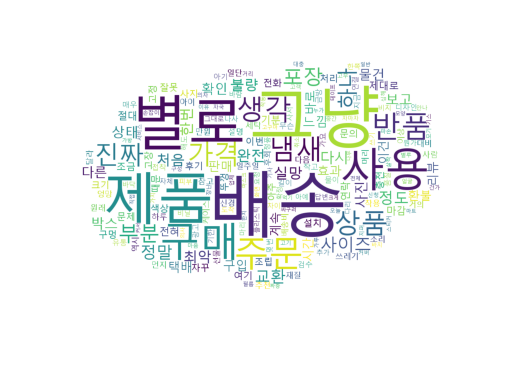

In [43]:
wc = word_count_dict

wordCloud = WordCloud(
    font_path = "malgun",        # 폰트 지정
    background_color = 'white',  # 배경색 지정
    stopwords = stopwords,       # 불용어 지정
    mask = mask,                 # 워드 클라우드 mask 지정
    width = 1000,                # 워드 클라우드의 너비 지정
    height = 1000,               # 워드클라우드의 높이 지정
    # max_font_size=100,         # 가장 빈도수가 높은 단어의 폰트 사이즈 지정
).generate_from_frequencies(wc)  # 워드 클라우드 빈도수 지정

plt.figure()  
plt.imshow(wordCloud)
plt.axis('off')
plt.show();

In [44]:
wordCloud.words_

{'배송': 1.0,
 '그냥': 0.8804247460757156,
 '별로': 0.6632040627885504,
 '제품': 0.5955678670360111,
 '사용': 0.5685595567867036,
 '구매': 0.5551708217913204,
 '주문': 0.44967682363804246,
 '반품': 0.44113573407202217,
 '생각': 0.37442289935364725,
 '냄새': 0.3670360110803324,
 '상품': 0.36426592797783935,
 '가격': 0.3407202216066482,
 '진짜': 0.3344875346260388,
 '부분': 0.3317174515235457,
 '하나': 0.31786703601108035,
 '포장': 0.3125577100646353,
 '사이즈': 0.30863342566943675,
 '정말': 0.2737765466297322,
 '교환': 0.2566943674976916,
 '정도': 0.25,
 '다시': 0.22276084949215144,
 '실망': 0.22045244690674054,
 '완전': 0.22022160664819945,
 '한번': 0.2146814404432133,
 '불량': 0.20313942751615882,
 '처음': 0.19990766389658357,
 '최악': 0.19852262234533702,
 '사진': 0.1904432132963989,
 '박스': 0.1819021237303786,
 '상태': 0.1814404432132964,
 '보고': 0.17890120036934443,
 '물건': 0.16897506925207756,
 '다른': 0.1682825484764543,
 '확인': 0.16528162511542013,
 '택배': 0.1530470914127424,
 '느낌': 0.15143120960295475,
 '판매': 0.14312096029547552,
 '구입': 0.141

## (2) Score_2_Review

In [5]:
text = ''
filePath = './data/Score_2_Review.txt'
with open(filePath, "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        text += line

In [6]:
vect = CountVectorizer(tokenizer = lambda x : text_cleaning(x))
bow_vect = vect.fit_transform([text])
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis = 0)

word_count_dict = dict(zip(word_list, count_list))

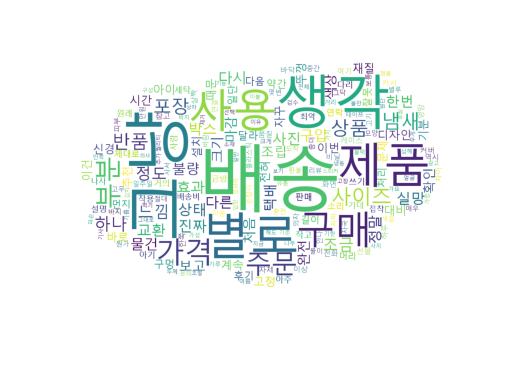

In [9]:
wc = word_count_dict

wordCloud = WordCloud(
    font_path = "malgun",        # 폰트 지정
    background_color = 'white',  # 배경색 지정
    stopwords = stopwords,       # 불용어 지정
    mask = mask,                 # 워드 클라우드 mask 지정
    width = 1000,                # 워드 클라우드의 너비 지정
    height = 1000,               # 워드클라우드의 높이 지정
    # max_font_size=100,         # 가장 빈도수가 높은 단어의 폰트 사이즈 지정
).generate_from_frequencies(wc)  # 워드 클라우드 빈도수 지정

plt.figure()  
plt.imshow(wordCloud)
plt.axis('off')
plt.show();

In [10]:
wordCloud.words_

{'배송': 1.0,
 '그냥': 0.8492143943233654,
 '생각': 0.630638621388748,
 '별로': 0.5785605676634566,
 '제품': 0.527749619868221,
 '사용': 0.5059553978712621,
 '구매': 0.46794221996958946,
 '가격': 0.4353775975671566,
 '부분': 0.3826659908768373,
 '주문': 0.3647997972630512,
 '사이즈': 0.34401926001013683,
 '냄새': 0.31335529650278765,
 '상품': 0.3044855549923974,
 '포장': 0.28370501773948303,
 '반품': 0.28066396350734923,
 '하나': 0.22529143436391283,
 '느낌': 0.21908261530663964,
 '정도': 0.20831221490116575,
 '조금': 0.20400405473897618,
 '상태': 0.17600101368474405,
 '교환': 0.17245311708058794,
 '사진': 0.17042574759249873,
 '실망': 0.16839837810440952,
 '다시': 0.16687785098834262,
 '진짜': 0.16409021794221998,
 '정말': 0.16066903193106943,
 '택배': 0.14989863152559554,
 '효과': 0.14977192093258995,
 '다른': 0.14888494678155093,
 '박스': 0.1485048150025342,
 '한번': 0.14673086670045615,
 '불량': 0.14052204764318296,
 '구입': 0.1398884946781551,
 '물건': 0.1383679675620882,
 '보고': 0.13355296502787634,
 '완전': 0.13253928028383172,
 '크기': 0.129118094272

## (3) Score_4_Review

In [11]:
text = ''
filePath = './data/Score_4_Review.txt'
with open(filePath, "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        text += line

In [12]:
vect = CountVectorizer(tokenizer = lambda x : text_cleaning(x))
bow_vect = vect.fit_transform([text])
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis = 0)

word_count_dict = dict(zip(word_list, count_list))

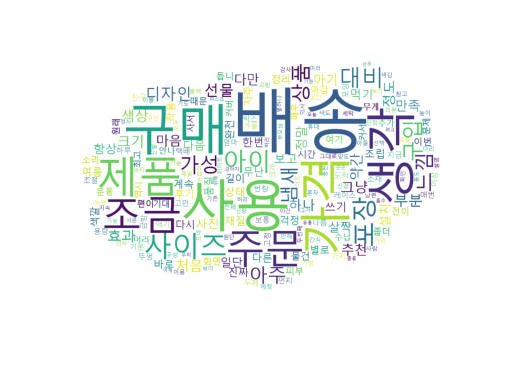

In [13]:
wc = word_count_dict

wordCloud = WordCloud(
    font_path = "malgun",        # 폰트 지정
    background_color = 'white',  # 배경색 지정
    stopwords = stopwords,       # 불용어 지정
    mask = mask,                 # 워드 클라우드 mask 지정
    width = 1000,                # 워드 클라우드의 너비 지정
    height = 1000,               # 워드클라우드의 높이 지정
    # max_font_size=100,         # 가장 빈도수가 높은 단어의 폰트 사이즈 지정
).generate_from_frequencies(wc)  # 워드 클라우드 빈도수 지정

plt.figure()  
plt.imshow(wordCloud)
plt.axis('off')
plt.show();

In [14]:
wordCloud.words_

{'배송': 1.0,
 '사용': 0.5735395189003436,
 '구매': 0.5329896907216495,
 '가격': 0.49759450171821307,
 '생각': 0.4618556701030928,
 '제품': 0.3302405498281787,
 '조금': 0.28969072164948456,
 '주문': 0.28350515463917525,
 '사이즈': 0.27079037800687283,
 '포장': 0.22646048109965636,
 '아이': 0.20549828178694157,
 '대비': 0.17972508591065292,
 '구입': 0.1577319587628866,
 '가성': 0.1556701030927835,
 '상품': 0.15532646048109966,
 '느낌': 0.15429553264604812,
 '아주': 0.15429553264604812,
 '냄새': 0.15360824742268042,
 '디자인': 0.15120274914089346,
 '선물': 0.13814432989690723,
 '부분': 0.13264604810996564,
 '효과': 0.1281786941580756,
 '색상': 0.12439862542955327,
 '약간': 0.12439862542955327,
 '크기': 0.12302405498281786,
 '그냥': 0.12164948453608247,
 '정도': 0.12130584192439862,
 '처음': 0.11855670103092783,
 '마음': 0.10824742268041238,
 '하나': 0.10687285223367697,
 '다만': 0.10652920962199312,
 '추천': 0.10549828178694158,
 '정말': 0.0986254295532646,
 '만족': 0.09690721649484536,
 '아기': 0.09484536082474226,
 '설치': 0.09072164948453608,
 '사진': 0.08659

## (4) Score_5_Review

In [15]:
text = ''
filePath = './data/Score_5_Review.txt'
with open(filePath, "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        text += line

In [16]:
vect = CountVectorizer(tokenizer = lambda x : text_cleaning(x))
bow_vect = vect.fit_transform([text])
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis = 0)

word_count_dict = dict(zip(word_list, count_list))

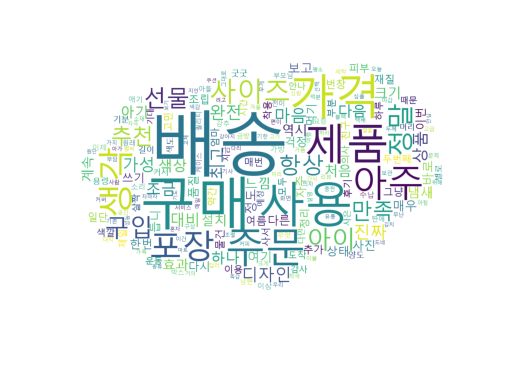

In [17]:
wc = word_count_dict

wordCloud = WordCloud(
    font_path = "malgun",        # 폰트 지정
    background_color = 'white',  # 배경색 지정
    stopwords = stopwords,       # 불용어 지정
    mask = mask,                 # 워드 클라우드 mask 지정
    width = 1000,                # 워드 클라우드의 너비 지정
    height = 1000,               # 워드클라우드의 높이 지정
    # max_font_size=100,         # 가장 빈도수가 높은 단어의 폰트 사이즈 지정
).generate_from_frequencies(wc)  # 워드 클라우드 빈도수 지정

plt.figure()  
plt.imshow(wordCloud)
plt.axis('off')
plt.show();

In [18]:
wordCloud.words_

{'배송': 1.0,
 '구매': 0.5969490764974201,
 '사용': 0.4141927764899424,
 '가격': 0.39190907051521723,
 '제품': 0.3251327301278696,
 '주문': 0.3188514170343229,
 '아주': 0.2539445150676737,
 '생각': 0.2501308606894489,
 '포장': 0.21513497345397442,
 '사이즈': 0.21034921109698645,
 '정말': 0.20414267554026772,
 '아이': 0.16869812308382562,
 '구입': 0.16181858969565543,
 '선물': 0.1471621924773798,
 '항상': 0.14245120765721977,
 '추천': 0.13018769161743812,
 '만족': 0.13011291408061018,
 '디자인': 0.1299633590069543,
 '진짜': 0.12801914304942796,
 '마음': 0.12637403723921334,
 '상품': 0.1212143871980857,
 '가성': 0.12099005458760188,
 '완전': 0.12054138936663426,
 '최고': 0.11949450385104314,
 '조금': 0.10483810663276752,
 '대비': 0.10423988633814402,
 '색상': 0.0960891348238989,
 '다음': 0.09579002467658715,
 '하나': 0.09549091452927541,
 '아기': 0.09025648695131983,
 '처음': 0.08748971808868616,
 '크기': 0.08591938981529948,
 '느낌': 0.07889030135347341,
 '설치': 0.07889030135347341,
 '효과': 0.07806774844836611,
 '역시': 0.0776190832273985,
 '냄새': 0.07672175